<a href="https://colab.research.google.com/github/AndreaMorbello/Progetto-IA2/blob/main/Notebooks/Notebook-IA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [33]:
# Impostazioni grafiche
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")


# Notebook Progetto Baseline

## 1. Introduzione al Progetto

### 1.1. Obiettivo del Modello

L'obiettivo di questo progetto è sviluppare un modello di regressione in grado di stimare il punteggio ELO del giocatore con i pezzi bianchi a partire da feature estratte da una singola partita.
Questo modello, denominato modello baseline, sarà successivamente confrontato con un secondo modello ... [DA COMPLETARE]

### 1.2. Limiti del Modello

**A. Rumore nei dati**

Questo modello stima il punteggio ELO di un giocatore utilizzando esclusivamente dati provenienti da una singola partita. Poiché la performance in una singola partita può variare significativamente rispetto al livello medio del giocatore (a causa di fattori quali concentrazione, forma del giorno, errori occasionali, o scelte strategiche particolari), stiamo di fatto lavorando con un campione altamente rumoroso dell'abilità reale del giocatore. Inoltre, il modello baseline utilizza feature non direttamente indicative della qualità del gioco (come vedremo nella sezione delle feature).

Per questi motivi, non ci aspettiamo un modello estremamente preciso e valuteremo criticamente eventuali metriche di accuratezza eccessivamente elevate, che potrebbero indicare overfitting o altre problematiche.

**B. Importanza delle feature e information leakage**

Tra le feature utilizzate (presentate nel punto 1.4 e successivamente selezionate nella sezione 2.1/b), ce n'è una chiaramente più informativa delle altre: `black_rating`. Questo deriva dal meccanismo di matchmaking utilizzato dai siti di scacchi online, che tendono ad accoppiare giocatori con punteggi ELO simili per garantire partite equilibrate.
(Questo non è vero universalmente, all'interno di tornei o partite amichevoli questa regola può non valere).

Di conseguenza, il modello avrà inevitabilmente una struttura approssimabile a:

**white_rating ≈ black_rating ± f(altre feature)**

dove f rappresenta una funzione correttiva basata sulle altre feature disponibili. Questa situazione rappresenta un caso di information leakage parzialmente controllato: `black_rating` contiene informazioni altamente correlate con il target, ma non lo determina completamente, lasciando spazio alle altre feature per catturare le differenze individuali e contestuali.

**C. Partite classificate vs non classificate**

È ragionevole ipotizzare che la performance del modello possa essere inferiore per le partite non classificate (rated=False), ovvero quelle che non influenzano il punteggio ELO dei giocatori. Il motivo è che molti giocatori potrebbero affrontare queste partite con minore serietà o utilizzarle per sperimentare strategie non convenzionali, dato che un'eventuale sconfitta non avrebbe conseguenze sul loro rating ufficiale.

Questa ipotesi potrà essere verificata attraverso un'analisi comparativa delle performance del modello sui due sottoinsiemi di dati.

### 1.3. Note sul Target

Il target del modello, `white_rating`, rappresenta il punteggio ELO del giocatore che conduce i pezzi bianchi. Il sistema ELO (https://it.wikipedia.org/wiki/Elo_(scacchi)) è un metodo per calcolare il livello relativo di abilità dei giocatori in giochi a due giocatori a somma zero, come gli scacchi.

**Aspetto temporale cruciale**: È fondamentale specificare che `white_rating` si riferisce al punteggio che il giocatore possedeva immediatamente prima dell'inizio della partita, non dopo la sua conclusione. Nelle partite classificate (rated=True), il punteggio ELO viene aggiornato al termine della partita in base a:
- Il rating pre-partita di entrambi i giocatori
- Il risultato effettivo della partita
- Il risultato atteso (calcolato dalla differenza di rating)
- Altri parametri come il fattore K (che dipende dal numero di partite giocate)

Il nostro obiettivo non è invertire l'algoritmo di calcolo del punteggio ELO, bensì utilizzare tale punteggio come proxy (approssimatore imperfetto ma ragionevole) del livello di abilità scacchistica del giocatore in quel momento specifico.

### 1.4. Presentazione del Dataset

Il dataset utilizzato proviene da Kaggle ed è disponibile al seguente indirizzo:
https://www.kaggle.com/datasets/datasnaek/chess

Il dataset originale contiene 20.058 partite di scacchi disputate sulla piattaforma Lichess. Ogni partita è descritta dalle seguenti variabili:

- **id**: Stringa alfanumerica identificativa univoca della partita
- **rated**: Variabile booleana che indica se la partita è classificata (True) e quindi influenza il rating ELO dei giocatori, oppure non classificata (False)
- **created_at**: Timestamp di inizio della partita in formato Unix time
- **last_move_at**: Timestamp di conclusione della partita in formato Unix time
- **turns**: Numero di turni completi, dove ogni turno è definito come una coppia di mosse (bianco-nero)
- **victory_status**: Modalità di conclusione della partita (scacco matto, abbandono, tempo esaurito, stallo, ecc.)
- **winner**: Colore del giocatore vincente (white, black) o draw in caso di patta
- **increment_code**: Formato temporale della partita espresso come "minuti iniziali+secondi di incremento per mossa" (es. "10+0" indica 10 minuti per giocatore senza incremento)
- **white_id**: Nome utente del giocatore con i pezzi bianchi
- **white_rating**: Punteggio ELO del giocatore bianco (pre-partita)
- **black_id**: Nome utente del giocatore con i pezzi neri
- **black_rating**: Punteggio ELO del giocatore nero (pre-partita)
- **moves**: Sequenza completa delle mosse della partita in notazione algebrica standard (SAN - Standard Algebraic Notation)
- **opening_eco**: Codice di classificazione dell'apertura secondo l'Encyclopaedia of Chess Openings (ECO)
- **opening_name**: Nome descrittivo dell'apertura utilizzata
- **opening_ply**: Numero di ply (mezze-mosse) che costituiscono la fase di apertura classificata della partita


### 1.5. Importazione del Dataset

In [34]:
###INSERIRE CODICE PER IMPORTAZIONE

In [35]:
## Quando ultimeremo il codice sarebbe meglio non fare montare il drive.
from google.colab import drive
drive.mount('/content/drive')

df=pd.read_csv("/content/drive/MyDrive/games.csv")
df_originale = df.copy() # Salviamo una copia del DataFrame originale

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Pulizia e preprocessing
### 2.1. Pulizia

#### a) Rimozione dei duplicati

Durante l'ispezione iniziale del dataset è stata rilevata la presenza di 945 record con identificativo (`id`) duplicato. Dopo aver verificato che si trattasse effettivamente di righe identiche in tutte le colonne, e non di partite diverse erroneamente associate allo stesso ID, abbiamo proceduto alla rimozione delle righe ridondanti, mantenendo una sola istanza per ciascun ID univoco.

In [36]:
# Individuiamo gli ID che compaiono più di una volta
dup_ids = df['id'].value_counts()
dup_ids = dup_ids[dup_ids > 1]

print(f"Numero di ID duplicati: {len(dup_ids)}")

colonne_da_controllare = [c for c in df.columns if c != 'id']

identical_check = (
    df[df['id'].isin(dup_ids.index)]
    .groupby('id')[colonne_da_controllare]
    .nunique()
    .max(axis=1)
)

identical_check.value_counts()

Numero di ID duplicati: 813


,count
2,516
1,297


In [37]:
# Notiamo che alcune righe (516) non condividono valori identici per tutte le colonne, verifichiamo perché:
id_problematici = identical_check[identical_check > 1].index

df[df['id'].isin(id_problematici)] \
  .groupby('id')[colonne_da_controllare] \
  .nunique() \
  .head()

# Le colonne non identiche sono quelle di inizio e fine partita, dunque il problema
# è probabilmente dovuto a un problema di datatype o di misurazione nel dataset.
# Le partite sono semanticamente identiche.
# Possiamo quindi procedere con la rimozione dei duplicati.

df = df.drop_duplicates(subset='id').reset_index(drop=True)

b) *Eliminazione delle colonne del dataframe non necessarie*:
Saranno certamente ininfluenti gli ID dei giocatori, ID della partita e il nome dell'apertura (prediligeremo usare il più rigoroso opening ECO).
Il discorso è più complicato per quanto riguarda le mosse. Intuitivamente per valutare il livello di un giocatore queste sarebbero fondamentali, tuttavia, almeno per il modello baseline, proveremo a fare le nostre valutazioni senza prenderle in considerazione.

In [38]:
df = df.drop(columns=['white_id','black_id','id','opening_name','moves'])

c) *Trasformazione delle colonne di inizio e fine partita in una colonna di durata*

In [39]:
#Ora convertiamo le colonne di inizio e fine partita, che sono in formato Unix time, in formato datetime
#Dopodichè inseriremo una più semplice colonna di durata partita al posto delle due colonne iniziali

df_times = df[['created_at','last_move_at']].copy()

df_times['created_at_dt'] = pd.to_datetime(df_times['created_at']/1000, unit='s', origin='unix')

df_times['last_move_at_dt'] = pd.to_datetime(df_times['last_move_at']/1000, unit='s', origin='unix')

df_times['created_time'] = df_times['created_at_dt'].dt.time
df_times['last_move_time'] = df_times['last_move_at_dt'].dt.time
df_times['duration_seconds'] = (df_times['last_move_at_dt'] - df_times['created_at_dt']).dt.total_seconds()

#Adesso che abbiamo la durata della partita in secondi, inseriamo la colonna nel dataframe e rimuoviamo quelle iniziali

df=df.drop(columns=['created_at','last_move_at'])
df=df.join(df_times['duration_seconds'])

#Ora invece ci occupiamo della colonna 'increment_code', che è della forma "X+Y"
#dove X sono i minuti concessi a ciascun giocatore per giocare le proprie mosse e Y
#è il tempo che gli viene riaggiunto una volta giocata la mossa.
#Vogliamo separare questi due valori e tenerli in colonne separate

#Split di increment_code in due colonne
df[['base_time', 'increment_time']] = (
    df['increment_code'].str.split('+', expand=True).astype(int))

#Rimuoviamo la colonna originale
df = df.drop(columns=['increment_code'])

df.tail(5)

,rated,turns,victory_status,winner,white_rating,black_rating,opening_eco,opening_ply,duration_seconds,base_time,increment_time
19108,True,24,resign,white,1691,1220,A80,2,321.734,10,10
19109,True,82,mate,black,1233,1196,A41,2,744.219,10,0
19110,True,35,mate,white,1219,1286,D00,3,172.834,10,0
19111,True,109,resign,white,1360,1227,B07,4,946.699,10,0
19112,True,78,mate,black,1235,1339,D00,3,736.699,10,0


d) Gestione delle variabili categoriche:

- Opening ECO. Questo è un sistema complesso. Per i nostri scopi sarà sufficiente sapere che classifica le aperture in cinque grandi famiglie:
A -> Aperture atipiche; B -> Sistemi semiaperti; C -> Partite di Re aperte e Francesi;  D -> Partite di Donna;                             E -> Difese Indiane.    
Questa è un'approsimazione ma ci consente di creare comunque dei dummy ristretti ma informativi riguardo al tipo di apertura giocata.

In [40]:
# Opening ECO semplificato

df['opening_category'] = df['opening_eco'].str[0]
df = df.drop(columns=['opening_eco'])

colonne_categoriali = ['rated', 'victory_status', 'winner', 'opening_category']

df = pd.get_dummies(df, columns=colonne_categoriali, dtype=int, drop_first=True)

df.head()

,turns,white_rating,black_rating,opening_ply,duration_seconds,base_time,increment_time,rated_True,victory_status_mate,victory_status_outoftime,victory_status_resign,winner_draw,winner_white,opening_category_B,opening_category_C,opening_category_D,opening_category_E
0,13,1500,1191,5,0.0,15,2,0,0,1,0,0,1,0,0,1,0
1,16,1322,1261,4,0.0,5,10,1,0,0,1,0,0,1,0,0,0
2,61,1496,1500,3,0.0,5,10,1,1,0,0,0,1,0,1,0,0
3,61,1439,1454,3,0.0,20,0,1,1,0,0,0,1,0,0,1,0
4,95,1523,1469,5,0.0,30,3,1,1,0,0,0,1,0,1,0,0


## 3. Analisi dei dati

### 3.1. Correlazione fra `white_rating` e `black_rating`

Come menzionato nell'introduzione, ci aspettiamo una forte correlazione tra i rating dei due giocatori, data la natura del matchmaking. Calcoliamo il coefficiente di correlazione di Pearson e visualizziamo la relazione.

Correlazione tra white_rating e black_rating: 0.6366


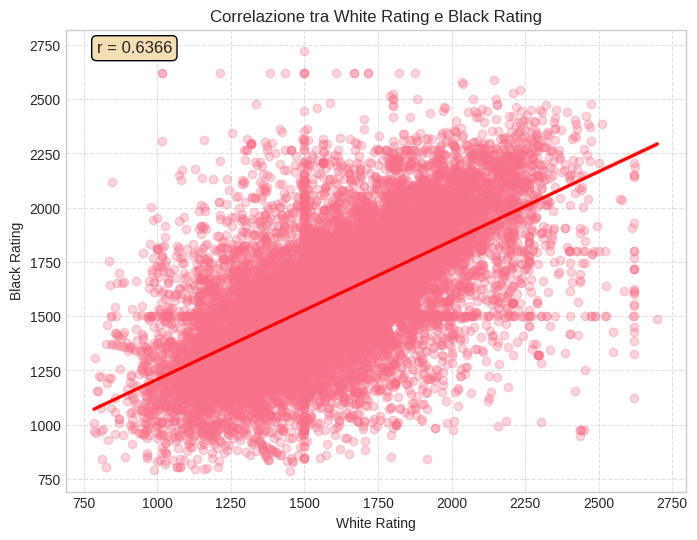

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation = df['white_rating'].corr(df['black_rating'])
print(f"Correlazione tra white_rating e black_rating: {correlation:.4f}")

plt.figure(figsize=(8, 6))
sns.regplot(x='white_rating', y='black_rating', data=df,
            scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
plt.title('Correlazione tra White Rating e Black Rating')
plt.xlabel('White Rating')
plt.ylabel('Black Rating')

plt.annotate(f'r = {correlation:.4f}', xy=(0.05, 0.95), xycoords='axes fraction',
             fontsize=12, bbox=dict(boxstyle='round', facecolor='wheat'))

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

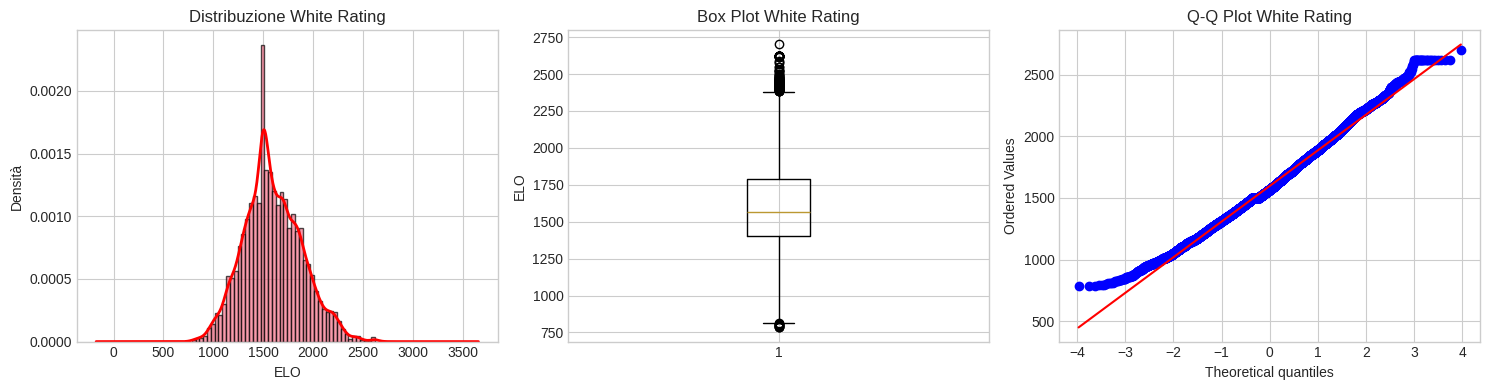

STATISTICHE TARGET (white_rating)
count    19113.000000
mean      1597.300005
std        290.022740
min        784.000000
25%       1401.000000
50%       1567.000000
75%       1792.000000
max       2700.000000
Name: white_rating, dtype: float64

Skewness: 0.2909
Kurtosis: 0.0216


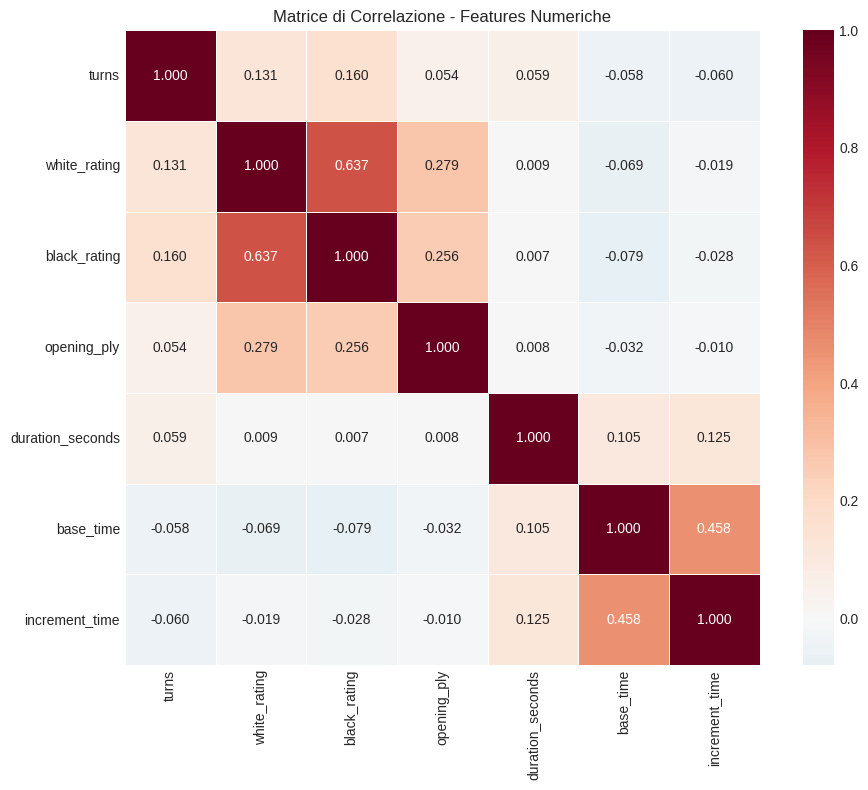

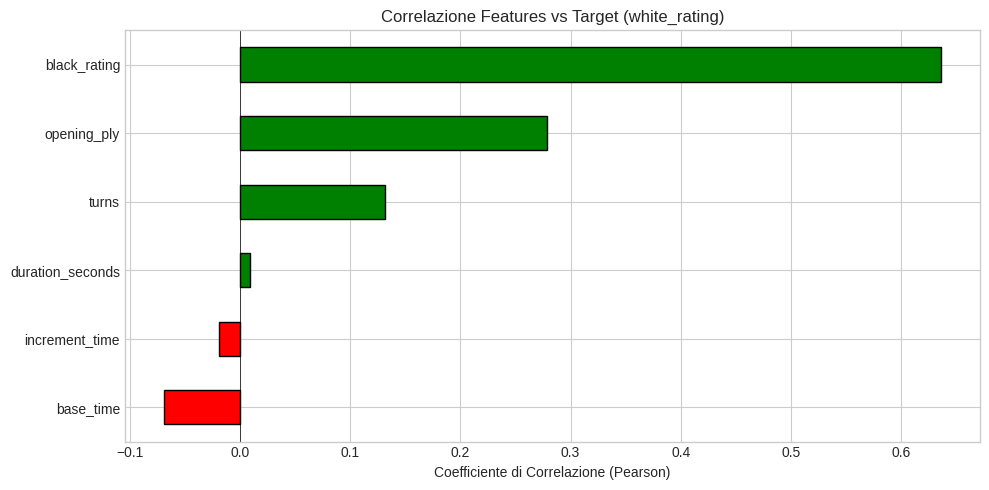


Correlazioni con white_rating:
black_rating        0.636569
opening_ply         0.278861
turns               0.131335
duration_seconds    0.009257
increment_time     -0.019090
base_time          -0.069447
Name: white_rating, dtype: float64


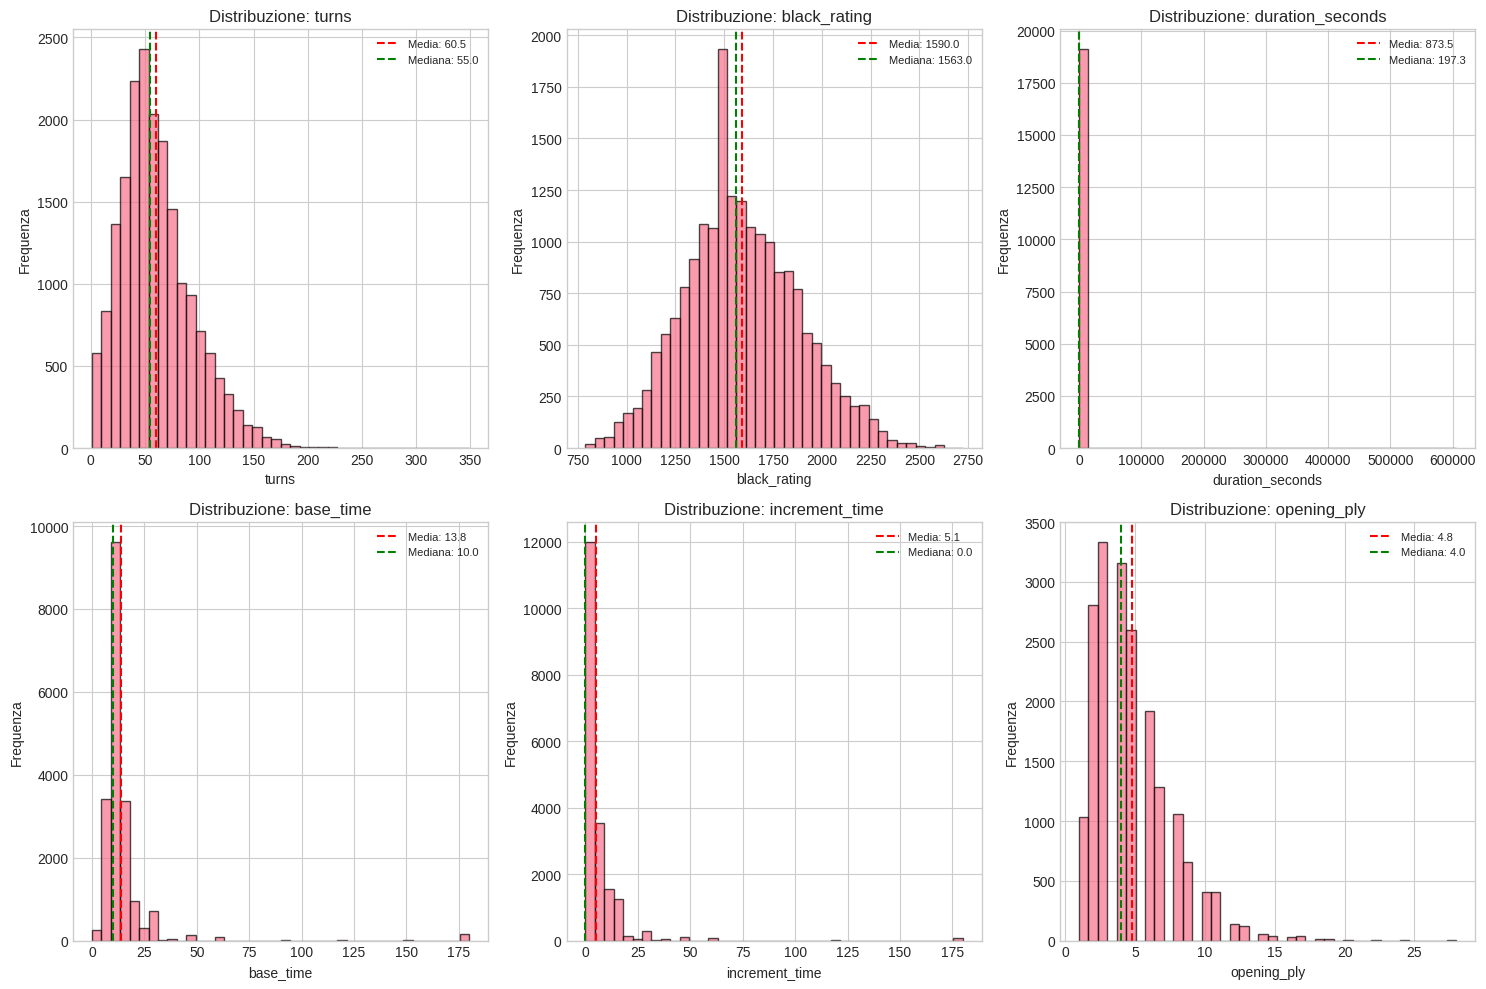


STATISTICHE FEATURES NUMERICHE
          turns  black_rating  duration_seconds  base_time  increment_time  \
count  19113.00      19113.00          19113.00   19113.00        19113.00   
mean      60.51       1590.05            873.45      13.79            5.15   
std       33.49        290.44           4927.36      17.07           13.81   
min        1.00        789.00              0.00       0.00            0.00   
25%       37.00       1394.00              0.00      10.00            0.00   
50%       55.00       1563.00            197.29      10.00            0.00   
75%       79.00       1785.00            781.05      15.00            7.00   
max      349.00       2723.00         605844.70     180.00          180.00   

       opening_ply  
count     19113.00  
mean          4.82  
std           2.80  
min           1.00  
25%           3.00  
50%           4.00  
75%           6.00  
max          28.00  


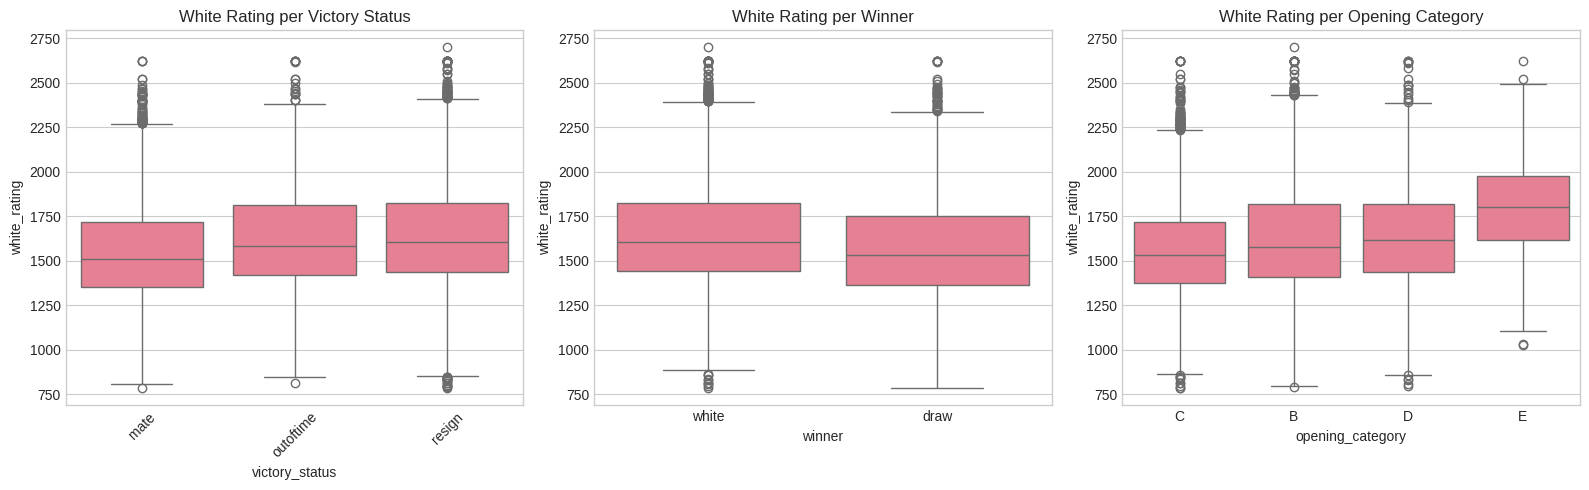


MEDIA WHITE_RATING PER CATEGORIA

victory_status:
                  mean  median    std  count
victory_status                              
mate            1544.5  1509.0  277.4   6820
outoftime       1612.4  1585.0  297.9   1598
resign          1628.7  1605.0  291.9  10695

winner:
          mean  median    std  count
winner                              
draw    1560.0  1534.0  286.5   9568
white   1634.7  1603.0  288.8   9545

opening_category:
                    mean  median    std  count
opening_category                              
B                 1610.0  1579.0  299.5   8783
C                 1558.1  1530.0  271.1   7279
D                 1627.4  1619.0  288.6   2562
E                 1794.7  1803.0  277.3    489


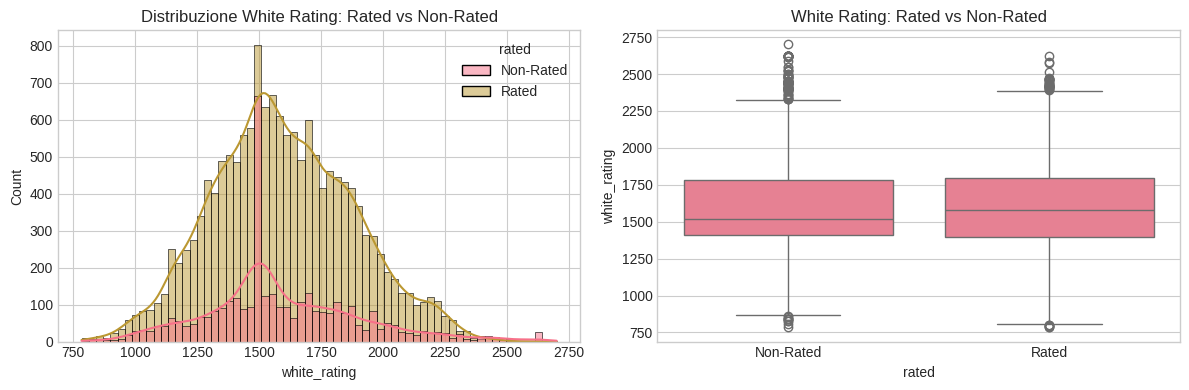


Statistiche Rated vs Non-Rated:
             count    mean    std    min     25%     50%     75%     max
rated                                                                   
Non-Rated   3646.0  1595.9  315.9  788.0  1412.0  1515.0  1779.8  2700.0
Rated      15467.0  1597.6  283.6  784.0  1399.0  1577.0  1794.0  2622.0

ANALISI OUTLIER

white_rating:
  Range IQR: [814.5, 2378.5]
  Outlier: 130 (0.68%)

black_rating:
  Range IQR: [807.5, 2371.5]
  Outlier: 92 (0.48%)

turns:
  Range IQR: [-26.0, 142.0]
  Outlier: 412 (2.16%)

duration_seconds:
  Range IQR: [-1171.6, 1952.6]
  Outlier: 1386 (7.25%)

CHECK DI CONSISTENZA

Partite con durata = 0s: 8533 (44.6%)
Partite con opening_ply > turns*2: 0
Partite con meno di 5 turni: 318 (1.7%)

Distribuzione controllo tempo (base_time in minuti):
base_time
10    8987
15    3219
5     1748
20     902
8      888
30     712
7      600
25     309
9      249
12     218
Name: count, dtype: int64


In [42]:
# -----------------------------------------------------------------------------
# 1. ANALISI DEL TARGET (white_rating)
# -----------------------------------------------------------------------------

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1a. Istogramma con KDE
axes[0].hist(df['white_rating'], bins=50, density=True, alpha=0.7, edgecolor='black')
df['white_rating'].plot.kde(ax=axes[0], color='red', linewidth=2)
axes[0].set_title('Distribuzione White Rating')
axes[0].set_xlabel('ELO')
axes[0].set_ylabel('Densità')

# 1b. Box plot
axes[1].boxplot(df['white_rating'], vert=True)
axes[1].set_title('Box Plot White Rating')
axes[1].set_ylabel('ELO')

# 1c. QQ plot (verifica normalità)
stats.probplot(df['white_rating'], dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot White Rating')

plt.tight_layout()
plt.show()

# Statistiche descrittive del target
print("="*50)
print("STATISTICHE TARGET (white_rating)")
print("="*50)
print(df['white_rating'].describe())
print(f"\nSkewness: {df['white_rating'].skew():.4f}")
print(f"Kurtosis: {df['white_rating'].kurtosis():.4f}")

# -----------------------------------------------------------------------------
# 2. MATRICE DI CORRELAZIONE (Features Numeriche)
# -----------------------------------------------------------------------------

# Seleziona solo le colonne numeriche non-dummy
numeric_cols = ['turns', 'white_rating', 'black_rating', 'opening_ply',
                'duration_seconds', 'base_time', 'increment_time']

# Verifica quali colonne esistono nel dataframe
numeric_cols = [col for col in numeric_cols if col in df.columns]

correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0,
            fmt='.3f', square=True, linewidths=0.5)
plt.title('Matrice di Correlazione - Features Numeriche')
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 3. CORRELAZIONI CON IL TARGET (Bar Plot Ordinato)
# -----------------------------------------------------------------------------

# Calcola correlazioni con white_rating (escluso se stesso)
target_corr = correlation_matrix['white_rating'].drop('white_rating').sort_values()

plt.figure(figsize=(10, 5))
colors = ['green' if x > 0 else 'red' for x in target_corr.values]
target_corr.plot(kind='barh', color=colors, edgecolor='black')
plt.title('Correlazione Features vs Target (white_rating)')
plt.xlabel('Coefficiente di Correlazione (Pearson)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

print("\nCorrelazioni con white_rating:")
print(target_corr.sort_values(ascending=False))

# -----------------------------------------------------------------------------
# 4. ANALISI UNIVARIATA - FEATURES NUMERICHE
# -----------------------------------------------------------------------------

features_to_analyze = ['turns', 'black_rating', 'duration_seconds',
                       'base_time', 'increment_time', 'opening_ply']
features_to_analyze = [f for f in features_to_analyze if f in df.columns]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(features_to_analyze):
    ax = axes[idx]
    ax.hist(df[feature], bins=40, alpha=0.7, edgecolor='black')
    ax.axvline(df[feature].mean(), color='red', linestyle='--', label=f'Media: {df[feature].mean():.1f}')
    ax.axvline(df[feature].median(), color='green', linestyle='--', label=f'Mediana: {df[feature].median():.1f}')
    ax.set_title(f'Distribuzione: {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequenza')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

# Statistiche descrittive per tutte le features numeriche
print("\n" + "="*50)
print("STATISTICHE FEATURES NUMERICHE")
print("="*50)
print(df[features_to_analyze].describe().round(2))

# -----------------------------------------------------------------------------
# 5. ANALISI FEATURES CATEGORICHE vs TARGET
# -----------------------------------------------------------------------------

# 5a. Box plot per victory_status
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Victory Status
victory_cols = [col for col in df.columns if col.startswith('victory_status_')]
if victory_cols:
    # Ricostruisci la variabile categorica
    df_temp = df.copy()
    df_temp['victory_status'] = df[victory_cols].idxmax(axis=1).str.replace('victory_status_', '')

    order = df_temp.groupby('victory_status')['white_rating'].median().sort_values().index
    sns.boxplot(data=df_temp, x='victory_status', y='white_rating', order=order, ax=axes[0])
    axes[0].set_title('White Rating per Victory Status')
    axes[0].tick_params(axis='x', rotation=45)

# Winner
winner_cols = [col for col in df.columns if col.startswith('winner_')]
if winner_cols:
    df_temp['winner'] = df[winner_cols].idxmax(axis=1).str.replace('winner_', '')

    sns.boxplot(data=df_temp, x='winner', y='white_rating', ax=axes[1])
    axes[1].set_title('White Rating per Winner')

# Opening Category
opening_cols = [col for col in df.columns if col.startswith('opening_category_')]
if opening_cols:
    df_temp['opening_category'] = df[opening_cols].idxmax(axis=1).str.replace('opening_category_', '')

    order = df_temp.groupby('opening_category')['white_rating'].median().sort_values().index
    sns.boxplot(data=df_temp, x='opening_category', y='white_rating', order=order, ax=axes[2])
    axes[2].set_title('White Rating per Opening Category')

plt.tight_layout()
plt.show()

# Tabella riassuntiva per categoria
print("\n" + "="*50)
print("MEDIA WHITE_RATING PER CATEGORIA")
print("="*50)
for cat_name, cat_col in [('victory_status', 'victory_status'),
                           ('winner', 'winner'),
                           ('opening_category', 'opening_category')]:
    if cat_col in df_temp.columns:
        print(f"\n{cat_name}:")
        print(df_temp.groupby(cat_col)['white_rating'].agg(['mean', 'median', 'std', 'count']).round(1))

# -----------------------------------------------------------------------------
# 6. ANALISI RATED vs NON-RATED
# -----------------------------------------------------------------------------

rated_cols = [col for col in df.columns if col.startswith('rated_')]
if rated_cols:
    df_temp['rated'] = df['rated_True'].map({1: 'Rated', 0: 'Non-Rated'})

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Distribuzione
    sns.histplot(data=df_temp, x='white_rating', hue='rated', kde=True, ax=axes[0])
    axes[0].set_title('Distribuzione White Rating: Rated vs Non-Rated')

    # Box plot
    sns.boxplot(data=df_temp, x='rated', y='white_rating', ax=axes[1])
    axes[1].set_title('White Rating: Rated vs Non-Rated')

    plt.tight_layout()
    plt.show()

    print("\nStatistiche Rated vs Non-Rated:")
    print(df_temp.groupby('rated')['white_rating'].describe().round(1))

# -----------------------------------------------------------------------------
# 7. OUTLIER DETECTION
# -----------------------------------------------------------------------------

print("\n" + "="*50)
print("ANALISI OUTLIER")
print("="*50)

for feature in ['white_rating', 'black_rating', 'turns', 'duration_seconds']:
    if feature not in df.columns:
        continue
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    print(f"\n{feature}:")
    print(f"  Range IQR: [{lower_bound:.1f}, {upper_bound:.1f}]")
    print(f"  Outlier: {len(outliers)} ({100*len(outliers)/len(df):.2f}%)")

# -----------------------------------------------------------------------------
# 8. ANALISI CONSISTENZA DATI
# -----------------------------------------------------------------------------

print("\n" + "="*50)
print("CHECK DI CONSISTENZA")
print("="*50)

# Partite con durata 0
if 'duration_seconds' in df.columns:
    zero_duration = (df['duration_seconds'] == 0).sum()
    print(f"\nPartite con durata = 0s: {zero_duration} ({100*zero_duration/len(df):.1f}%)")

# Opening ply > turns * 2
if 'opening_ply' in df.columns and 'turns' in df.columns:
    invalid_ply = (df['opening_ply'] > df['turns'] * 2).sum()
    print(f"Partite con opening_ply > turns*2: {invalid_ply}")

# Partite molto corte (< 5 mosse)
if 'turns' in df.columns:
    very_short = (df['turns'] < 5).sum()
    print(f"Partite con meno di 5 turni: {very_short} ({100*very_short/len(df):.1f}%)")

# Distribuzione controllo tempo
if 'base_time' in df.columns:
    print("\nDistribuzione controllo tempo (base_time in minuti):")
    print(df['base_time'].value_counts().head(10))